<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/pytorhc_Fashtion_attemptCOMP8221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Autoregressive Models**



### Introduction:



- A PixelCNN is a type of model that creates images by predicting each pixel's value based on the pixels that came before it. It breaks down the image into a series of related parts, making it easier to understand and generate.
In this project we will  implement a PixelCNN
of Autoregressive models using PyTorch.





## MaskedConv2d layer:
- MaskedConv2d is a specialized convolutional layer used in PixelCNN architectures to ensure that the network only uses information from pixels that have already been generated. This is crucial for maintaining the autoregressive property of the model, where each pixel's prediction depends only on previously generated pixels.

- it would hide the future pixel such that the model cannot see the future pixels when it was trained by kernal filters.

- We have two type of masks here. Type A excludes the center-most pixels and type B include the center-most pixel.



In [ ]:
import torch
import torch.nn as nn
#https://github.com/axeloh/pixelcnn-pytorch
class MaskedConv2d(nn.Conv2d):
    """Regular Masked Convolutional Layer"""
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride=1, padding=0, use_cuda=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)  #inherent 4 variables from parent class

        kH, kW = kernel_size, kernel_size
        self.device = torch.device('cuda') if use_cuda else None
        self.mask = torch.ones(out_channels, in_channels, kH, kW).to(self.device)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0   #Type A excludes the center-most pixels and type B include the center-most pixel.
        self.mask[:, :, kH // 2 + 1:] = 0   #set all rows equal to 0 after the row KH//2

        # Mask
        #         -------------------------------------
        #        |  1       1       1       1       1 |
        #        |  1       1       1       1       1 |
        #        |  1       1    1 if B     0       0 |   H // 2
        #        |  0       0       0       0       0 |   H // 2 + 1
        #        |  0       0       0       0       0 |
        #         -------------------------------------
        #  index    0       1     W//2    W//2+1

    def forward(self, x):
        self.weight.data *= self.mask                               # we applied the the mask into the weight.data inside the parent class
        return super(MaskedConv2d, self).forward(x)                 #call the forward method of parent class with existing implementation(subclass)



## PixelCNN:

- We build up a PixelCNN here:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.autograd import Variable


class PixelCNN(nn.Module):
    """ Simple PixelCNN architecture for modeling binary MNIST and shapes images """
    def __init__(self):
        super().__init__()
        num_filters = 64
        self.net = nn.Sequential(
            MaskedConv2d('A', 1, num_filters, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),

            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),  #we also have batch normalization
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, num_filters, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.BatchNorm2d(num_filters),

            MaskedConv2d('B', num_filters, num_filters, kernel_size=1, stride=1, padding=0), nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            MaskedConv2d('B', num_filters, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

##Dataset ,Preprocessing, Training and Generation:

- In this part we choose FashionMNIST as out dataset. We do the data preprocessing using To.tensor() ( including normalization) and We convert into binary tensor fof further training.

- We dont have data augmentation as it is not neceassry in this task.



- We trained our models with few epoches and our lost function is  binary_cross_entropy lost function.

- After training we generate some new samples from out model.



In [ ]:
from torchvision import transforms
from torchvision import datasets

def main(image_shape):
    """
        train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
        test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
        image_shape: (H, W), height and width of the image

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
        """

    def get_loss(output, batch):
        return F.binary_cross_entropy(output, batch)    #choose the binary_cross_entropy lost function

    def get_test_loss(data):
        tot_loss = []
        for batch in torch.split(data, 128):
            output = net((batch - .5) / .5)     #The line net((batch - .5) / .5) is normalizing the input data before passing it to the neural network
            tot_loss.append(get_loss(output, batch).item())
        return np.mean(np.array(tot_loss))

    # Model (forward(x)) expects shape to be (batch_size, channels, height, width)

    train_dataset = datasets.FashionMNIST(                     #We choose FashionMNIST Dataset with normalization toTensor()
    root='data',
    train=True,
    transform=transforms.Compose([

    transforms.ToTensor()
                  ]),
    download=True
           )
    test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=transforms.Compose([

    transforms.ToTensor()
                  ]),
    download=True
           )


    train_data=torch.stack([x[0] for x in train_dataset]).cuda()   #we only need image but not the labels to train our models.
    test_data=torch.stack([x[0] for x in test_dataset]).cuda()
    train_data = train_data > 0.5
    train_data = train_data.to(torch.uint8).float()        #convert into binary objects for simplicity.I choose other dataset which modify the
    #code little bit
    test_data = test_data > 0.5
    test_data = test_data.to(torch.uint8).float()


    net = PixelCNN().cuda()

    epochs = 8
    batch_size = 32
    batches = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    train_losses = []
    init_test_loss = get_test_loss(test_data)
    test_losses = [init_test_loss]

    # Training
    for epoch in range(epochs):
        for batch in batches:
            optimizer.zero_grad()
            output = net((batch - .5) / .5)
            loss = get_loss(output, batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        test_losses.append(get_test_loss(test_data))
        print(f'{epoch + 1}/{epochs} epochs')


    net.eval()

    # Sampling
    H, W = image_shape
    samples = torch.zeros(size=(20, 1, H, W)).cuda()
    #.cuda()
    with torch.no_grad():
        for i in range(H):
            for j in range(W):
                out = net((samples - .5) / .5)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

    return net,np.array(train_losses), np.array(test_losses), np.transpose(samples.detach().cpu().numpy(), [0, 2, 3, 1])

In [ ]:
#We run the code.
net,rain_loss,test_loss,generated_sample=main((28,28))

1/8 epochs
2/8 epochs
3/8 epochs
4/8 epochs
5/8 epochs
6/8 epochs
7/8 epochs
8/8 epochs


## Visualization :
- (a).We generate and visualize samples from the trained model:

- (b).Visualize and interpret the learned representations (e.g., using feature visualization techniques)


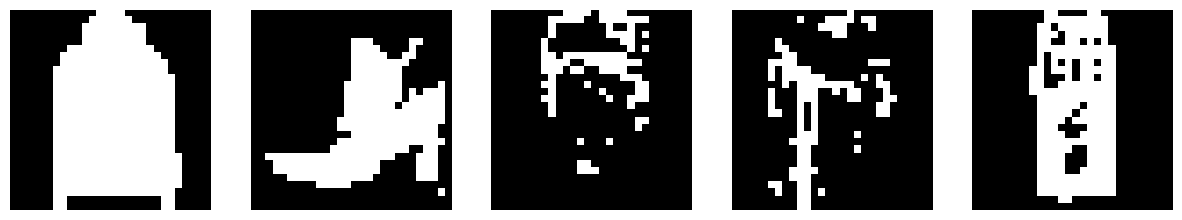

In [ ]:
#generate and visualize 5 samples from the trained model

import matplotlib.pyplot as plt

# Select random indices
indices = np.random.choice(len(generated_sample), 5, replace=False)

# Display selected images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_sample[indices[i], :, :, 0], cmap='gray')
    ax.axis('off')

plt.show()

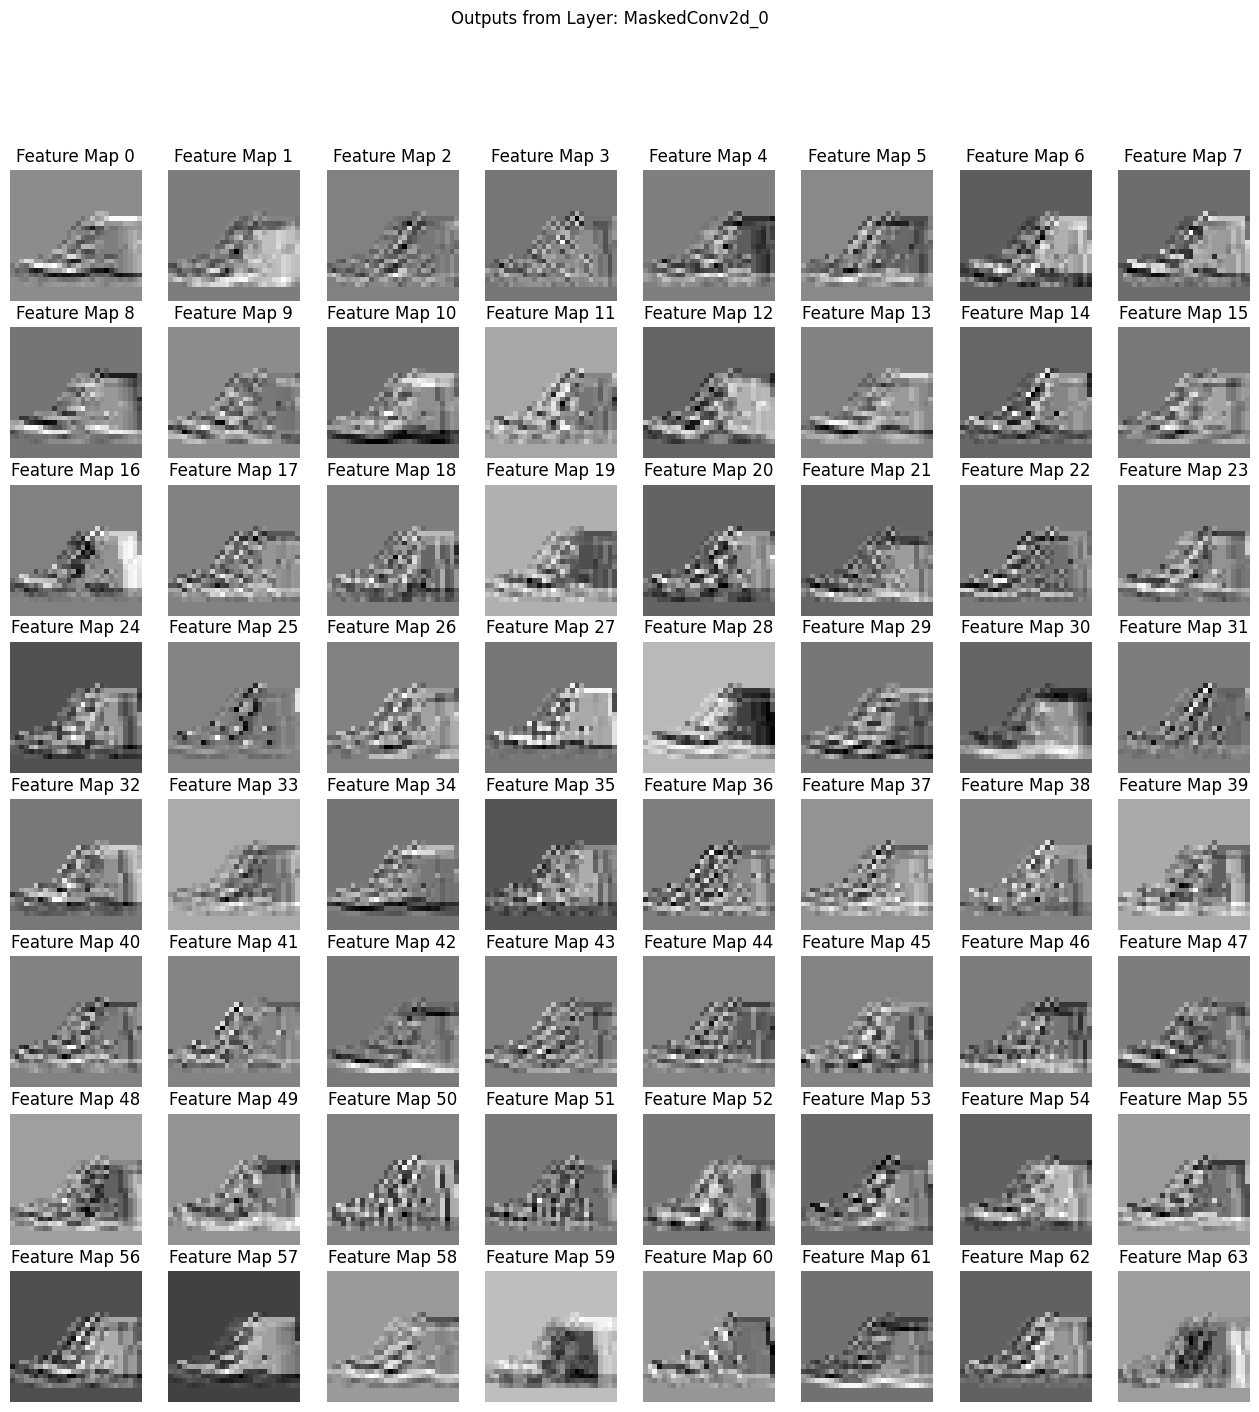

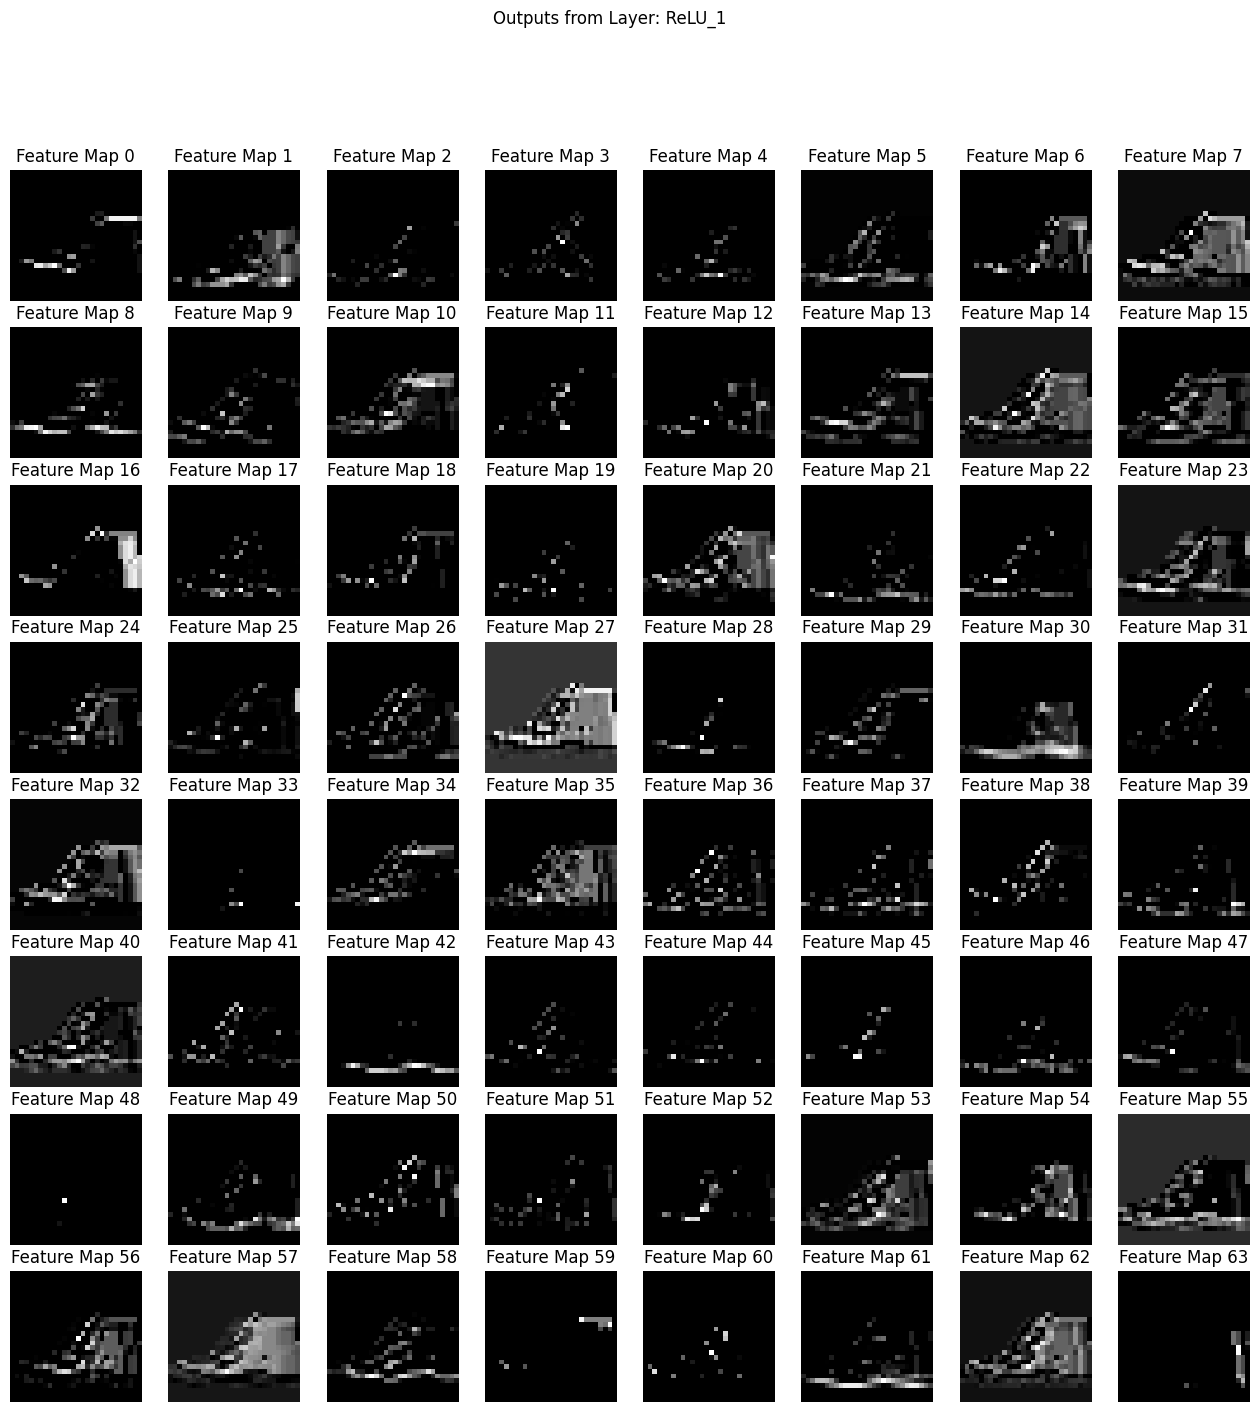

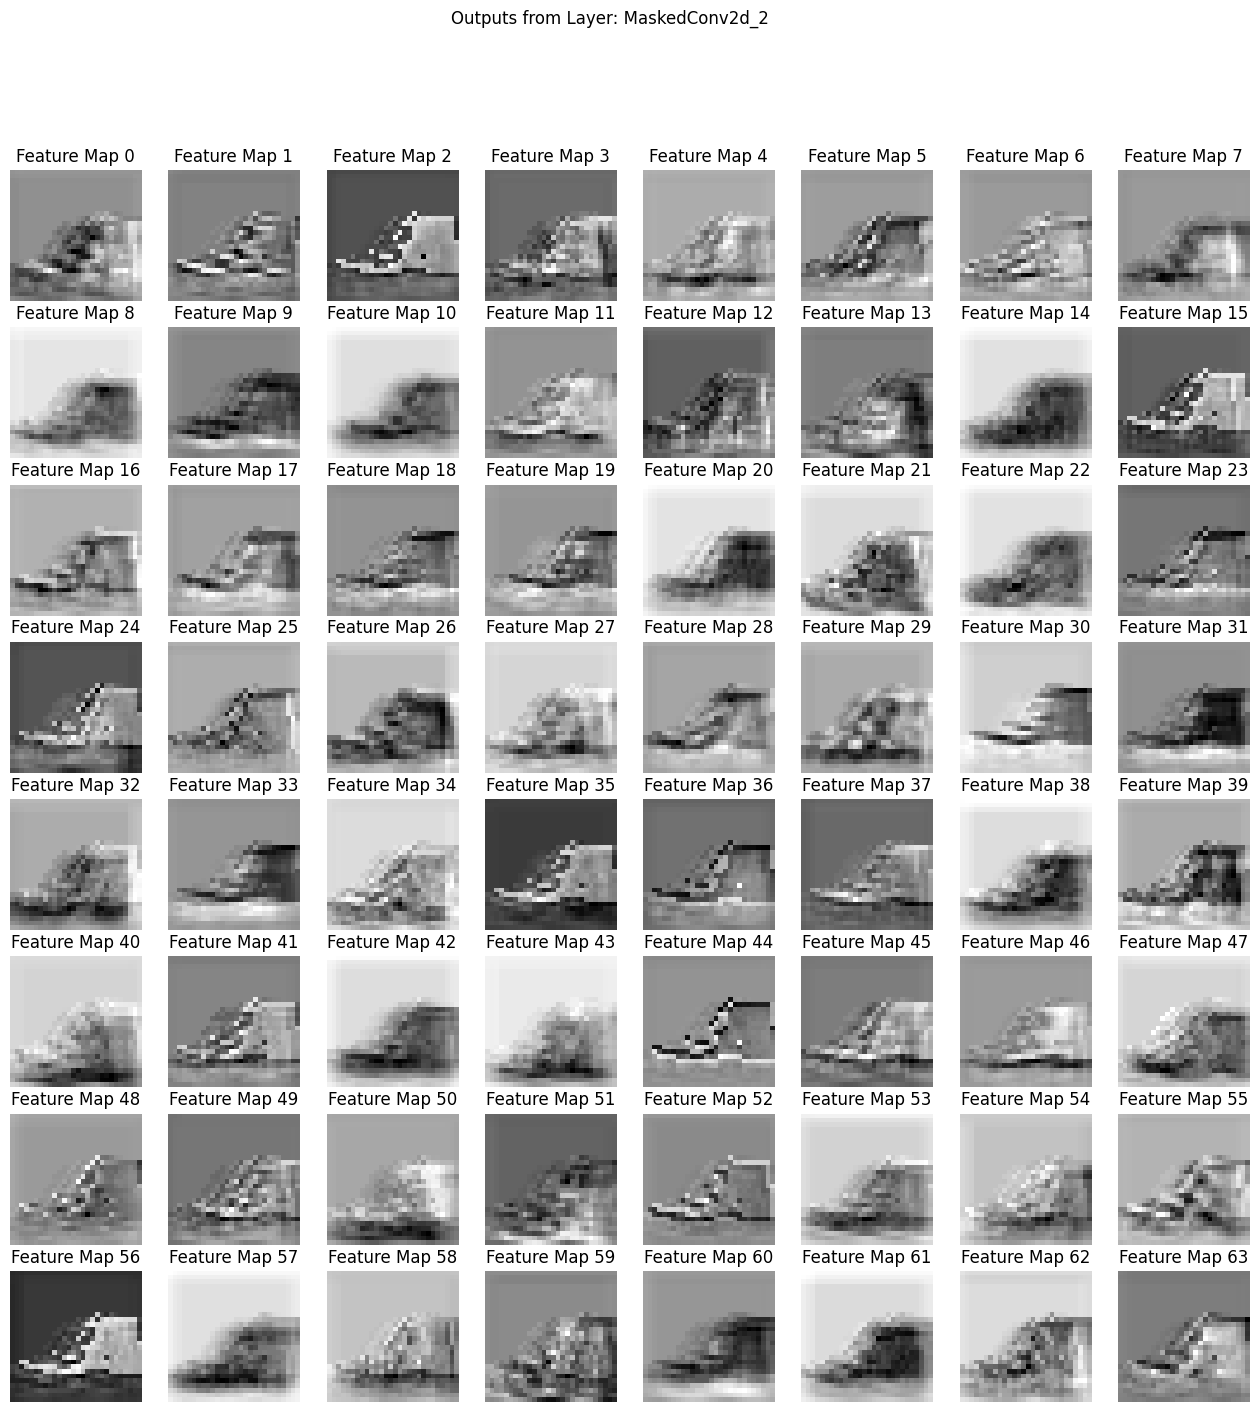

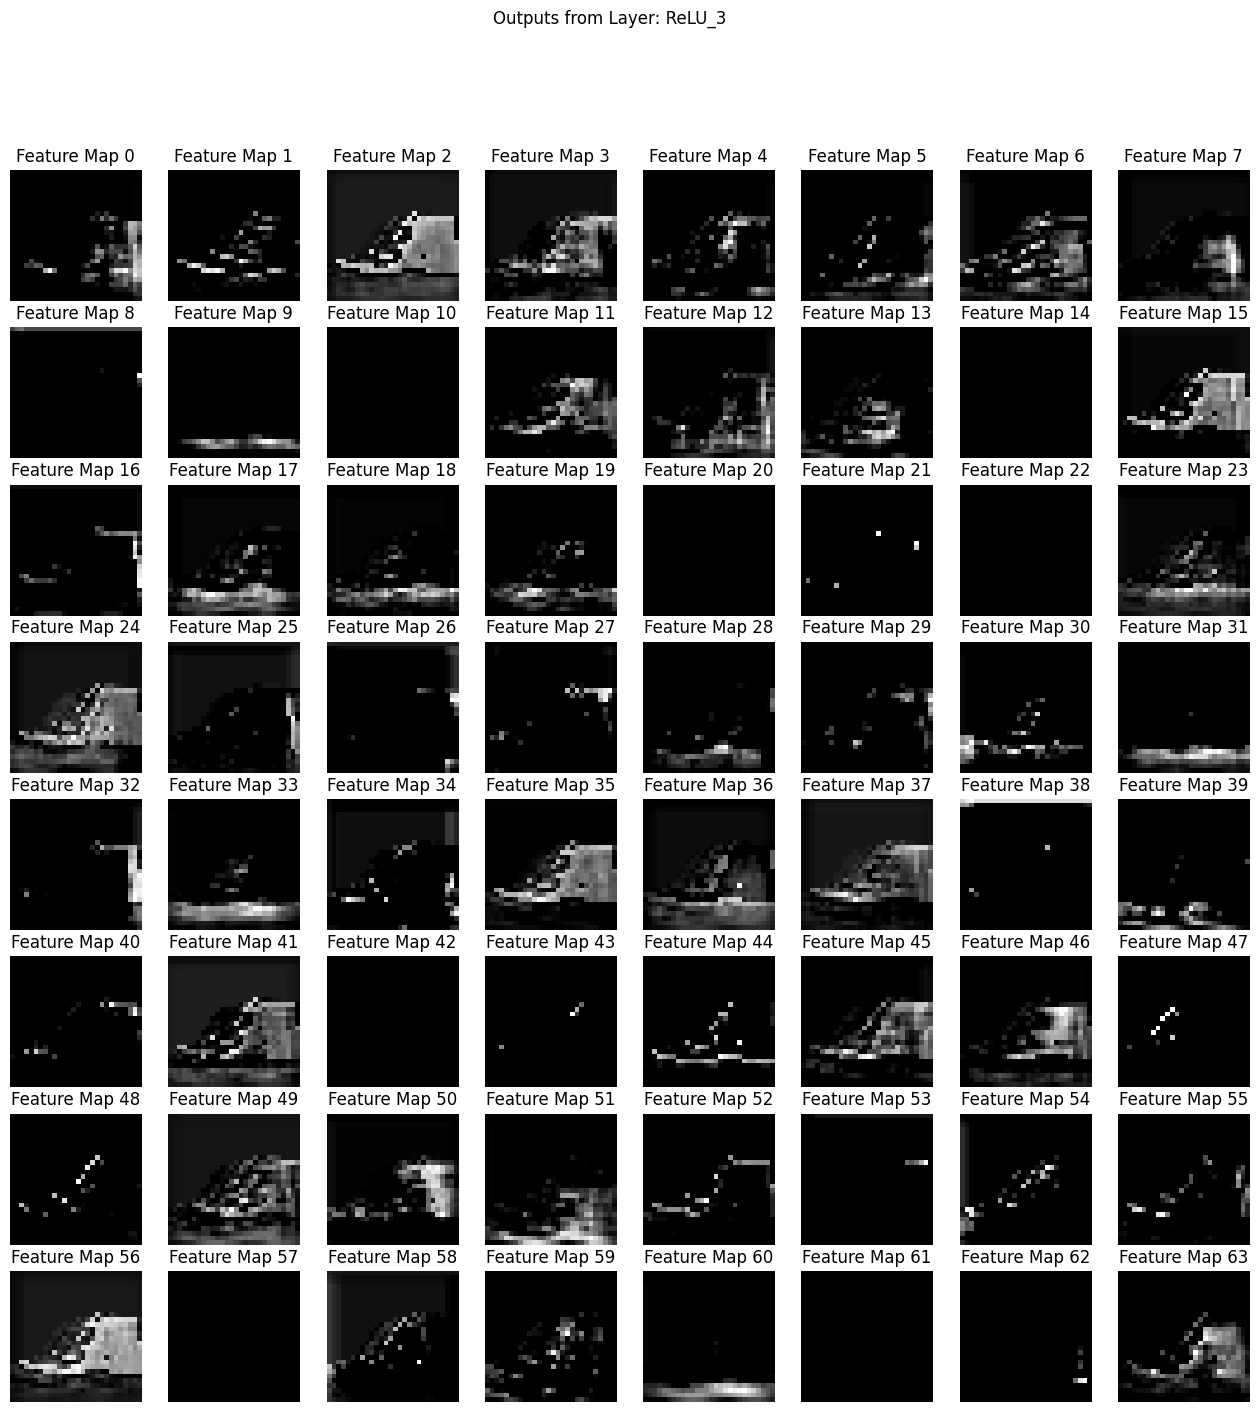

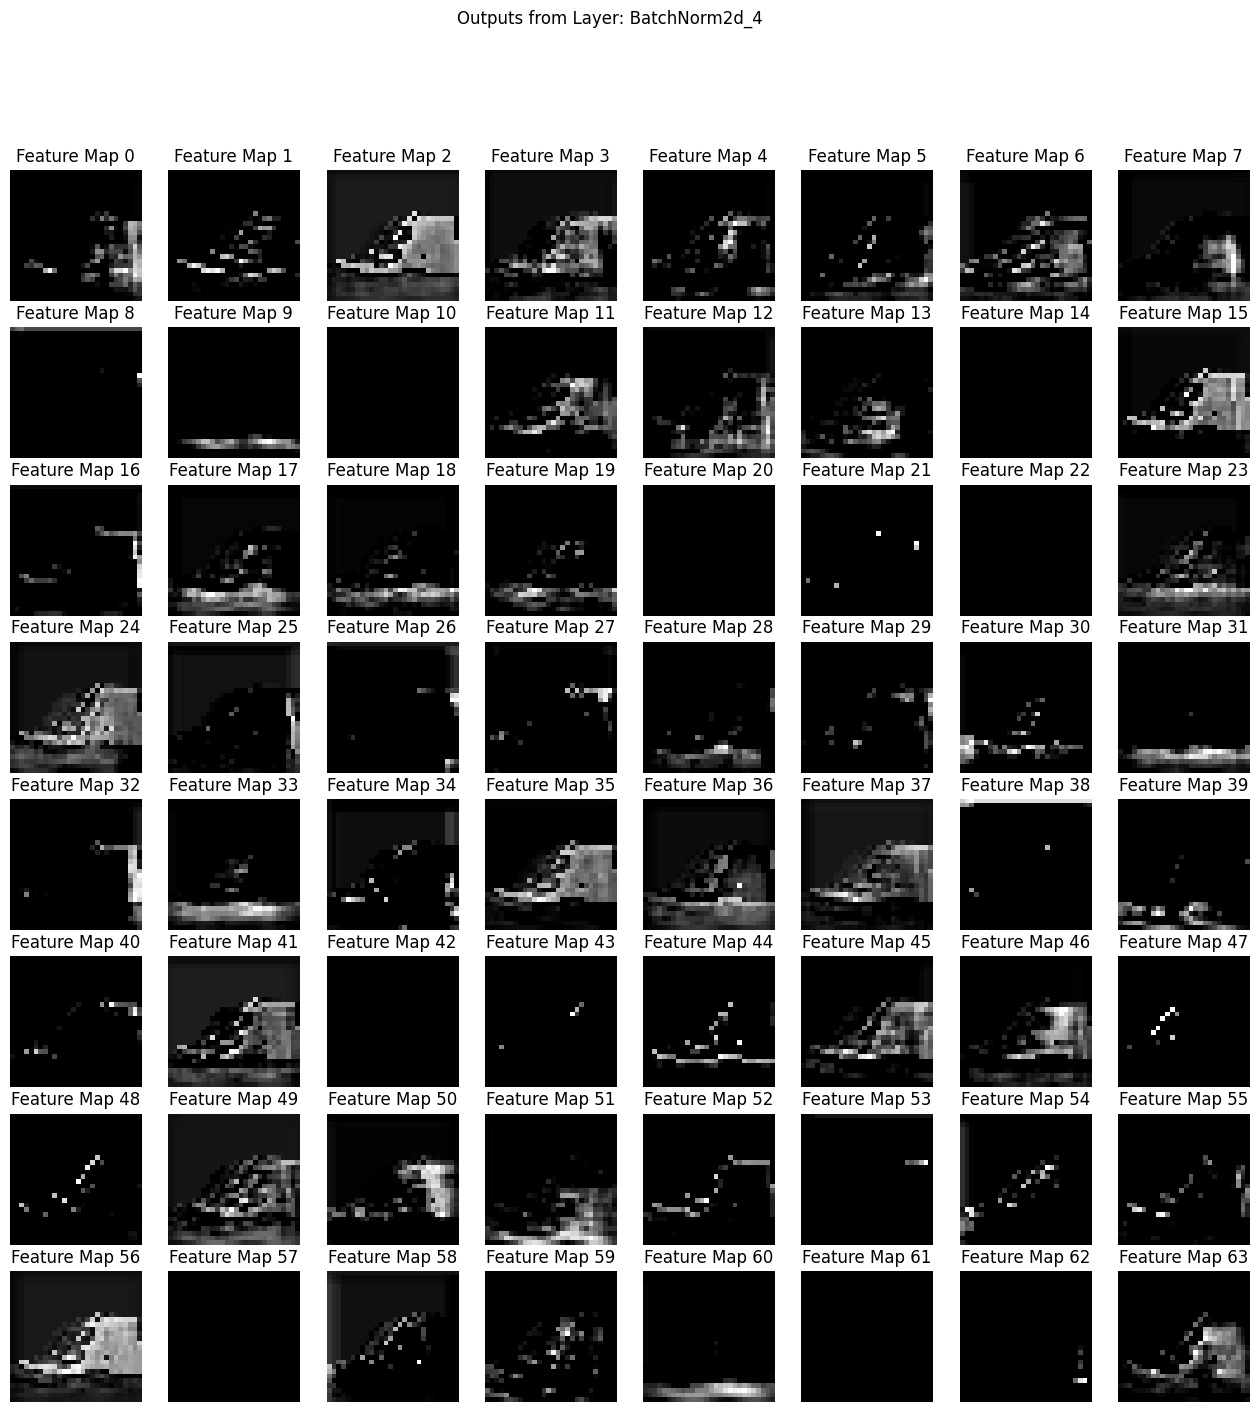

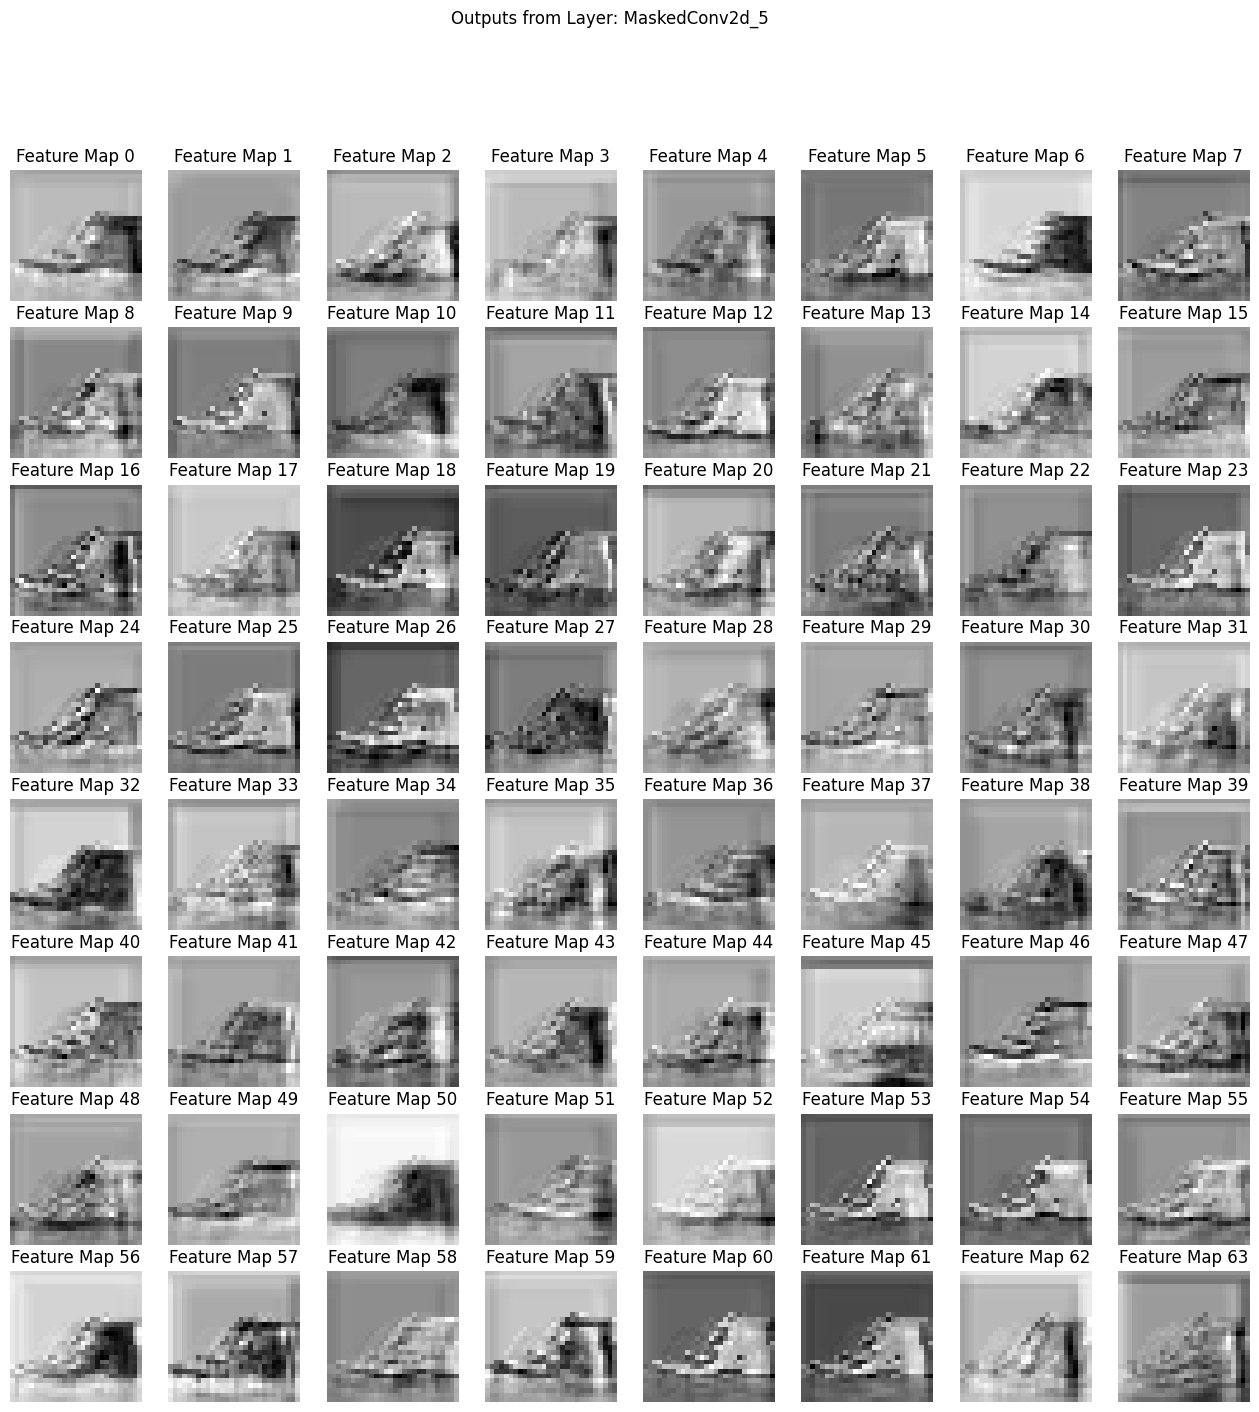

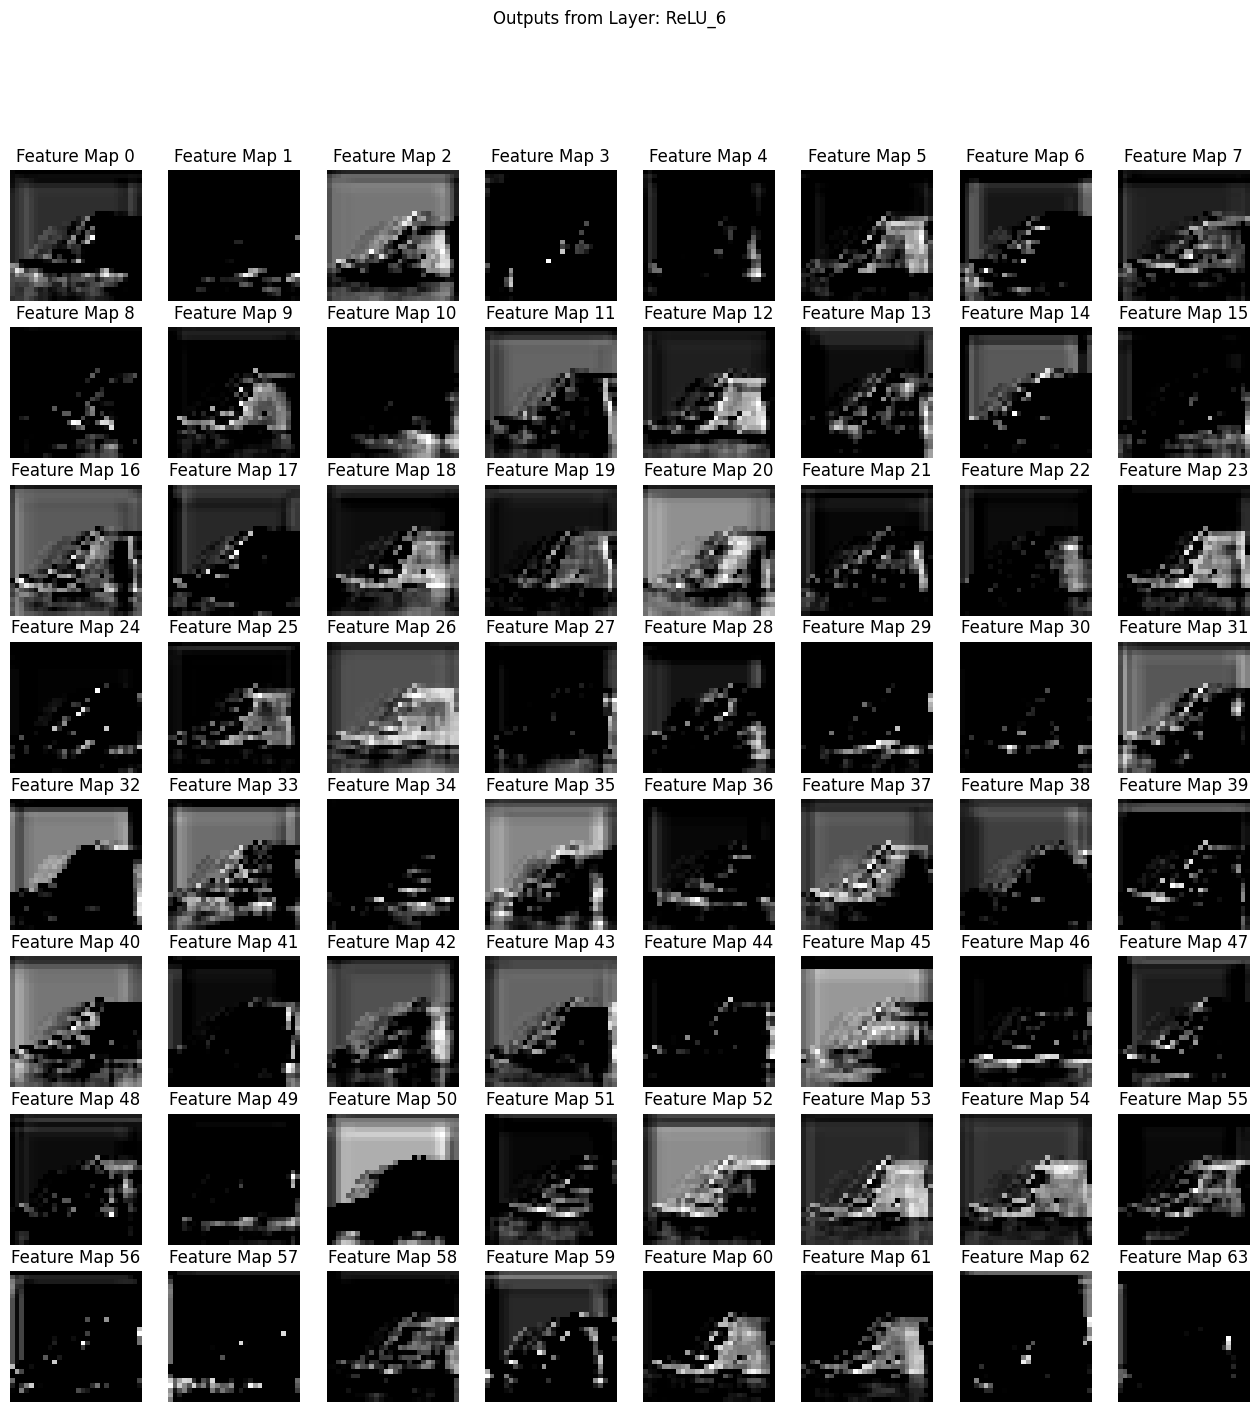

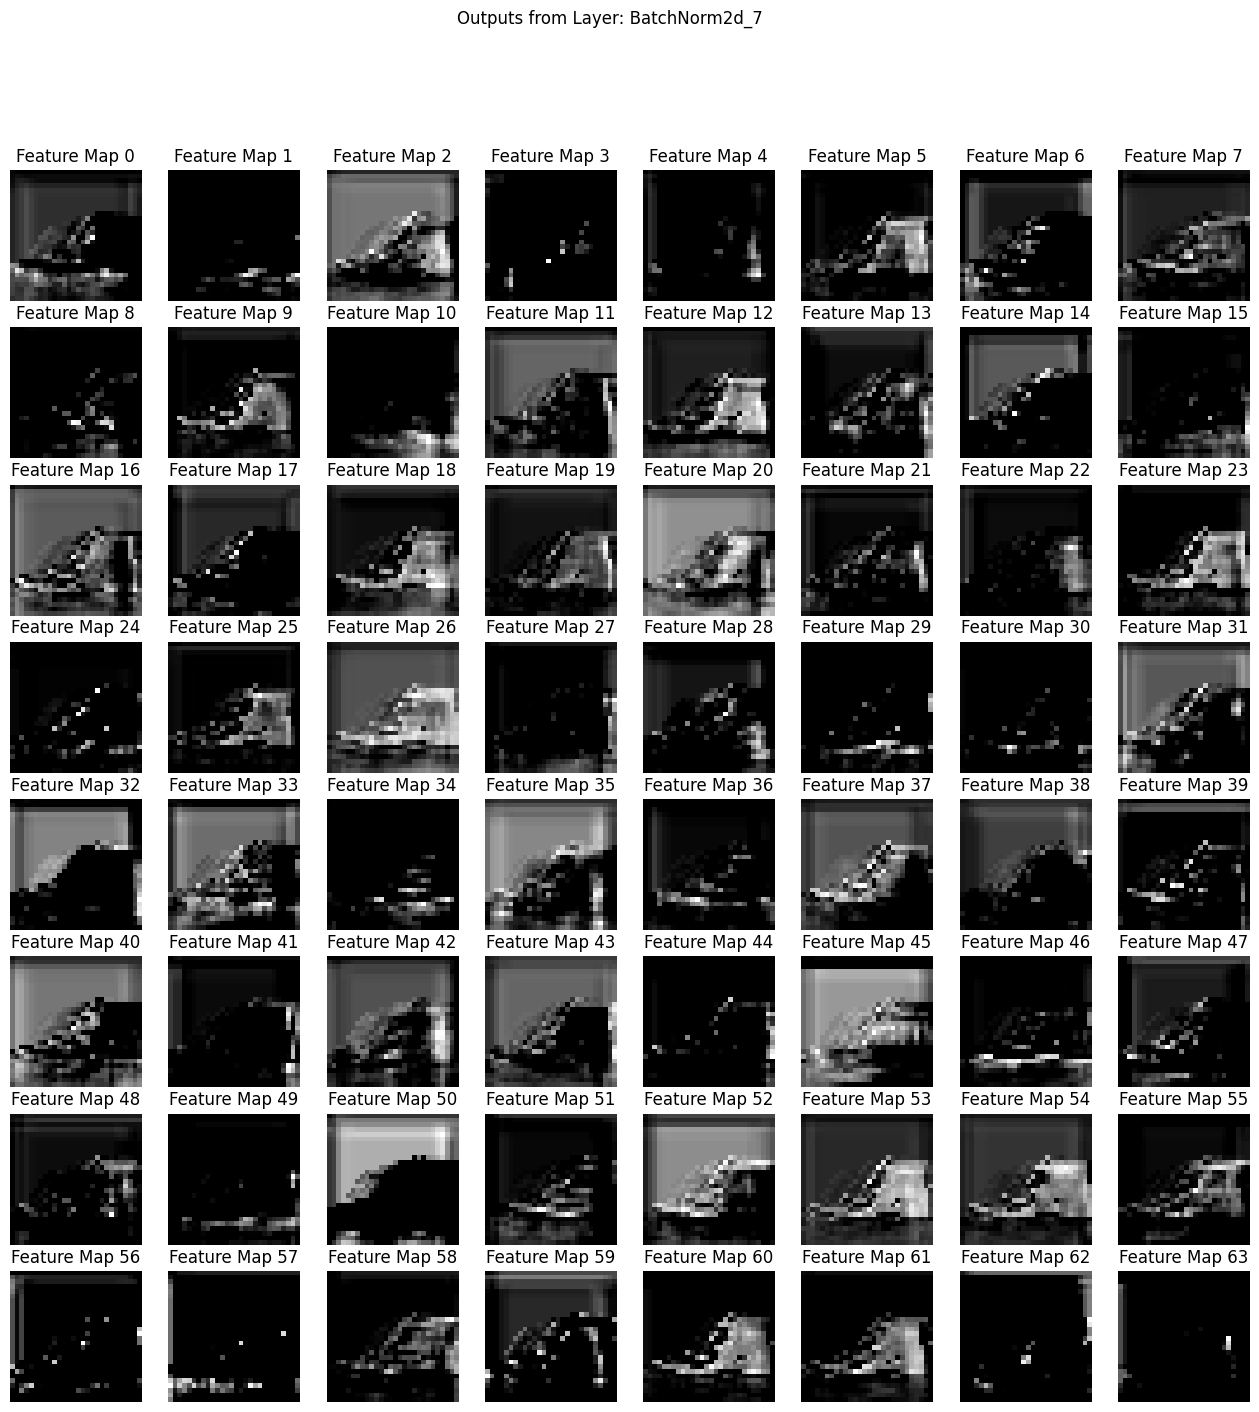

In [ ]:
#Visualize and interpret the learned representations (e.g., using feature visualization techniques)

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


test_dataset = datasets.FashionMNIST(
root='data',
train=False,
transform=transforms.Compose([

transforms.ToTensor()
              ]),
download=True
        )


test_data=torch.stack([x[0] for x in test_dataset]).cuda()

test_data = test_data > 0.5
test_data = test_data.to(torch.uint8).float()




# Initialize your network and test image

test_image = test_data[0].unsqueeze(0).cuda()

# Dictionary to store the outputs
outputs = {}
hooks = []  # List to store hook handles for removal later

# Hook function to capture the output of each layer
def hook_fn(module, input, output):
    layer_name = f"{module.__class__.__name__}_{len(outputs)}"
    outputs[layer_name] = output

# Function to register hooks
def register_hooks(net):
    global hooks
    # Clear previously registered hooks
    for hook in hooks:
        hook.remove()
    hooks.clear()

    # Register hooks only once for each relevant layer
    for layer in net.net:
        if isinstance(layer, (nn.Conv2d, MaskedConv2d, nn.BatchNorm2d, nn.ReLU, nn.Sigmoid)):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)  # Save hook handle for later removal

# Register hooks
register_hooks(net)

# Run a forward pass
net(test_image)

# Visualize the outputs
for layer_name, output in outputs.items():
    num_feature_maps = output.shape[1]  # Number of channels (feature maps)

    # Determine the number of columns and rows for the subplots
    num_cols = min(8, num_feature_maps)  # Limit to max 8 columns for readability
    num_rows = (num_feature_maps + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle(f'Outputs from Layer: {layer_name}')

    # Plot each feature map
    for i in range(num_feature_maps):
        ax = axs[i // num_cols, i % num_cols] if num_rows > 1 else axs[i % num_cols]
        ax.imshow(output[0, i].detach().cpu().numpy(), cmap='gray')
        ax.set_title(f'Feature Map {i}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs.flatten()[j])

    plt.show()